In [1]:
import numpy as np
import json
import warnings
import operator

import h5py
from keras.models import model_from_json
from keras import backend as K

from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

size_title = 18
size_label = 14
n_pred = 2

base_path = "data/evaluate_log_sum_sample/"

path_data_dict = base_path + "data_dict.txt"
path_inverted_wt = base_path + "inverted_weights.txt"
path_usage_wt = base_path + "usage_prediction.txt"
path_class_wt = base_path + "class_weights.txt"
path_test_data = base_path + "test_paths_dict.txt"
model_path = base_path + "trained_model.hdf5"

def read_file(file_path):
    with open(file_path, 'r') as data_file:
        data = json.loads(data_file.read())
    return data

class_weights = read_file(path_class_wt)
usage_weights = read_file(path_usage_wt)
inverted_weights = read_file(path_inverted_wt)
data_dict = read_file(path_data_dict)

def create_model(model_path):
    trained_model = h5py.File(model_path, 'r')
    model_config = json.loads(trained_model.get('model_config').value)
    loaded_model = model_from_json(model_config)
    dictionary = json.loads(trained_model.get('data_dictionary').value)
    compatibile_tools = json.loads(trained_model.get('compatible_tools').value)
    reverse_dictionary = dict((str(v), k) for k, v in dictionary.items())
    model_weights = list()
    weight_ctr = 0
    while True:
        try:
            d_key = "weight_" + str(weight_ctr)
            weights = trained_model.get(d_key).value
            model_weights.append(weights)
            weight_ctr += 1
        except Exception as exception:
            break
    # set the model weights
    loaded_model.set_weights(model_weights)
    return loaded_model, dictionary, reverse_dictionary, compatibile_tools

model, dictionary, reverse_dictionary, compatibile_tools = create_model(model_path)

Using TensorFlow backend.


In [30]:
reverse_dictionary

{'1': 'annotateMyIDs',
 '2': 'unicycler',
 '3': 'gatk_unified_genotyper',
 '4': 'qiime_core_diversity',
 '5': 'IDFilter',
 '6': 'deg_annotate',
 '7': 'mass_spectrometry_imaging_mzplots',
 '8': 'pileup_interval',
 '9': 'ncbi_blastx_wrapper',
 '10': 'heinz_scoring',
 '11': 'megahit',
 '12': 'FileConverter',
 '13': 'abims_xcms_fillPeaks',
 '14': 'Flash',
 '15': '16Saligner',
 '16': 'hisat2',
 '17': 'deeptools_compute_matrix',
 '18': 'mothur_summary_single',
 '19': 'meme_psp_gen',
 '20': 'jbrowse',
 '21': 'deeptools_compute_gc_bias',
 '22': 'gatk_depth_of_coverage',
 '23': 'gemini_db_info',
 '24': 'rbc_mirdeep2_mapper',
 '25': 'deeptools_plot_fingerprint',
 '26': 'DecoyDatabase',
 '27': 'abims_xcms_group',
 '28': 'TextExporter',
 '29': 'bedtools_slopbed',
 '30': 'porechop',
 '31': 'EMBOSS: getorf42',
 '32': 'gemini_interactions',
 '33': 'fastq_groomer',
 '34': 'mimodd_vcf_filter',
 '35': 'CONVERTER_fastqgz_to_fastq',
 '36': 'metilene',
 '37': 'enhanced_bowtie_wrapper',
 '38': 'bedtools_int

In [33]:
def verify_model(model, tool_sequence, labels, dictionary, reverse_dictionary, compatible_tools, topk=20, max_seq_len=25):
    tl_seq = tool_sequence.split(",")
    last_tool_name = reverse_dictionary[str(tl_seq[-1])]
    last_compatible_tools = compatible_tools[last_tool_name]
    sample = np.zeros(max_seq_len)
    for idx, tool_id in enumerate(tl_seq):
        sample[idx] = int(tool_id)
    sample_reshaped = np.reshape(sample, (1, max_seq_len))
    
    tool_sequence_names = [reverse_dictionary[str(tool_pos)] for tool_pos in tool_sequence.split(",")]
    print("Tool seq: %s" % ",".join(tool_sequence_names))
    # predict next tools for a test path
    prediction = model.predict(sample_reshaped, verbose=0)
    prediction = np.reshape(prediction, (prediction.shape[1],))
    prediction_pos = np.argsort(prediction, axis=-1)

    # get topk prediction
    topk_prediction_pos = prediction_pos[-topk:]
    topk_prediction_val = [np.round(prediction[pos] * 100, 2) for pos in topk_prediction_pos]

    # read tool names using reverse dictionary
    pred_tool_ids = [reverse_dictionary[str(tool_pos)] for tool_pos in topk_prediction_pos]
    actual_next_tool_ids = list(set(pred_tool_ids).intersection(set(last_compatible_tools.split(","))))      
        
    #print("Predicted tools: %s" % ",".join(pred_tool_ids))
    print()
    pred_tool_ids_sorted = dict()
    for (tool_pos, tool_pred_val) in zip(topk_prediction_pos, topk_prediction_val):
        tool_name = reverse_dictionary[str(tool_pos)]
        if tool_name in actual_next_tool_ids:
            pred_tool_ids_sorted[tool_name] = tool_pred_val
    pred_tool_ids_sorted = dict(sorted(pred_tool_ids_sorted.items(), key=lambda kv: kv[1], reverse=True))
    
    cls_wt = dict()
    usg_wt = dict()
    inv_wt = dict()
    ids_tools = dict()
    keys = list(pred_tool_ids_sorted.keys())
    for k in keys:
        try:
            cls_wt[k] = np.round(class_weights[str(data_dict[k])], 2)
            usg_wt[k] = np.round(usage_weights[k], 2)
            inv_wt[k] = np.round(inverted_weights[str(data_dict[k])], 2)
        except:
            continue
    print("Predicted tools: \n")
    print(pred_tool_ids_sorted)
    print()
    print("Class weights: \n")
    cls_wt = dict(sorted(cls_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(cls_wt)
    print()
    print("Usage weights: \n")
    usg_wt = dict(sorted(usg_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(usg_wt)
    print()
    total_usage_wt = np.mean(list(usg_wt.values()))
    print("Mean usage wt: %0.4f" % (total_usage_wt))
    print()
    print("Inverted weights: \n")
    inv_wt = dict(sorted(inv_wt.items(), key=lambda kv: kv[1], reverse=True))
    print(inv_wt)
    for key in pred_tool_ids_sorted:
        ids_tools[key] = dictionary[key]
    print()
    print("Tool ids")
    print(ids_tools)
    print("======================================")
    return cls_wt, usg_wt, inv_wt, pred_tool_ids_sorted

topk = 10
tool_seq = "555" # ,875,223,17
class_wt, usage_wt, inverse_wt, pred_tools = verify_model(model, tool_seq, "", dictionary, reverse_dictionary, compatibile_tools, topk)

Tool seq: Remove beginning1

Predicted tools: 

{'Grouping1': 7.59, 'addValue': 7.08, 'datamash_ops': 5.38, 'Cut1': 5.11, 'cat1': 3.45, 'wc_gnu': 3.1, 'Add_a_column1': 2.72, 'Filter1': 2.01, 'Show beginning1': 1.99, 'collection_column_join': 1.28}

Class weights: 

{'datamash_ops': 5.06, 'Add_a_column1': 4.08, 'Filter1': 3.11, 'wc_gnu': 2.99, 'collection_column_join': 2.89, 'Grouping1': 2.36, 'addValue': 2.34, 'Cut1': 1.8, 'Show beginning1': 1.47, 'cat1': 1.15}

Usage weights: 

{'Cut1': 1425.46, 'Filter1': 1021.1, 'addValue': 463.1, 'cat1': 428.07, 'Grouping1': 177.59, 'datamash_ops': 100.83, 'Show beginning1': 87.82, 'collection_column_join': 14.1, 'wc_gnu': 1.0, 'Add_a_column1': 1.0}

Mean usage wt: 372.0070

Inverted weights: 

{'datamash_ops': 157.06, 'Add_a_column1': 58.93, 'Filter1': 22.51, 'wc_gnu': 19.95, 'collection_column_join': 18.03, 'Grouping1': 10.63, 'addValue': 10.42, 'Cut1': 6.05, 'Show beginning1': 4.36, 'cat1': 3.15}

Tool ids
{'Grouping1': 611, 'addValue': 490, 'da

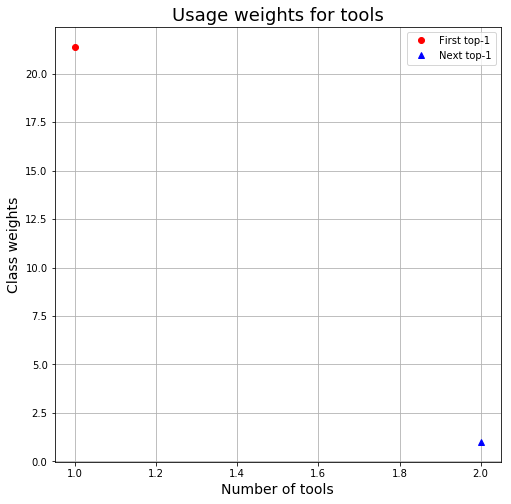

In [5]:
list_cls_wt = list()
list_usage_wt = list()
list_pred_wt = list()
list_inv_wt = list()
division_pt = int(len(pred_tools) / 2)

for tool in pred_tools:
    list_pred_wt.append(pred_tools[tool])
    #try:
    list_inv_wt.append(inverse_wt[tool])
    list_usage_wt.append(usage_wt[tool])
    #except:
    #list_inv_wt.append(1)

def plot_scatter(y_val, title, xlabel, ylabel):
    x_val = range(1, len(y_val) + 1)
    plt.figure(figsize=(8, 8))
    plt.plot(x_val[:division_pt], y_val[:division_pt], 'ro')
    plt.plot(x_val[division_pt:], y_val[division_pt:], 'b^')
    plt.xlabel(xlabel, size=size_label)
    plt.ylabel(ylabel, size=size_label)
    plt.legend([("First top-%s" % str(division_pt)), ("Next top-%s" % str(division_pt))])
    plt.title(title, size=size_title)
    plt.grid(True)
    plt.show()

plot_scatter(list_usage_wt, "Usage weights for tools", "Number of tools", "Class weights")
#plot_scatter(ave_prediction_weights, ave_usage_weights, "Prediction vs usage weights", "Prediction scores", "Usage weights")
#plot_scatter(ave_prediction_weights, ave_inverted_weights, "Prediction vs inverted weights", "Prediction scores", "Inverted weights")